# 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 필요한 도구 import

In [ ]:
pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 24.9 MB/s eta 0:00:00


In [ ]:
pip install opencv-python

In [ ]:
import cv2
import mediapipe as mp
import json
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

# 키포인트 좌표 추출

In [ ]:
import cv2
import mediapipe as mp

mp_hands = mp.solutions.hands

def video_landmark_dic(path):
    # 영상 파일 열기
    cap = cv2.VideoCapture(path)

    # Mediapipe Hands 모델 초기화
    landmark_dic = {}
    landmark_x = []
    landmark_y = []
    with mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
        # 영상에서 첫 번째 프레임만 읽기
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            # Mediapipe에 이미지 전달
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = hands.process(image_rgb)
            frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES)

            # 손이 감지된 경우
            if results.multi_hand_world_landmarks:
                for hand_landmarks, handedness in zip(results.multi_hand_world_landmarks, results.multi_handedness):
                    # 손의 라벨과 스코어 출력
                    hand_label = handedness.classification[0].label
                    hand_score = handedness.classification[0].score
                    # 각 랜드마크의 x, y 좌표와 손의 정확도, 프레임 번호, 키포인트 번호를 딕셔너리에 저장
                    for idx, landmark in enumerate(hand_landmarks.landmark):
                        landmark_x.append(landmark.x)
                        landmark_y.append(landmark.y)
                        landmark_dic[len(landmark_dic) + 1] = {'X': landmark.x, 'Y': landmark.y, 'C': hand_score, 't': int(frame_number), 'n': idx}
            X_max, X_min, Y_max, Y_min = max(landmark_x), min(landmark_x), max(landmark_y), min(landmark_y)
    cap.release()
    return landmark_dic, X_max, X_min, Y_max, Y_min



In [ ]:
dic, X_max, X_min, Y_max, Y_min = video_landmark_dic('/content/drive/MyDrive/3차 데이터/front_01/NIA_SL_WORD0001_REAL01_F.mp4')

# X, Y 좌표 정규화
- 각 영상의 키포인트 값 중 최대값과 최소값을 이용하요 정규화를 진행
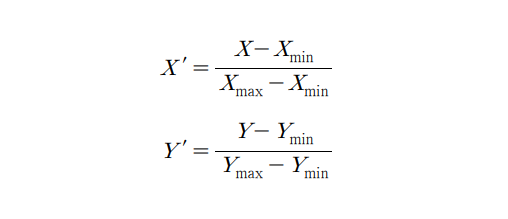

In [ ]:
dic[1]

{'X': -0.00030879327096045017,
 'Y': -0.03471890091896057,
 'C': 0.9822129011154175,
 't': 1,
 'n': 0}

In [ ]:
def dic_normalization(dic):
    for idx, (k, v) in enumerate(dic.items()):
        X = (dic[k]['X'] - X_min) / (X_max - X_min)
        Y = (dic[k]['Y'] - Y_min) / (Y_max - Y_min)
        dic[k]['X'] = X
        dic[k]['Y'] = Y
    return dic

In [ ]:
norm_dic = dic_normalization(dic)
print(norm_dic[1])

{'X': 0.4821313474347587, 'Y': 0.24546739612403656, 'C': 0.9822129011154175, 't': 1, 'n': 0}


# 키포인트 픽셀 매핑
- 정규화된 키포인트를 이미지로 만들기 위해 xy좌표계에서 RGB 색상 좌표계로 변환하는 과정
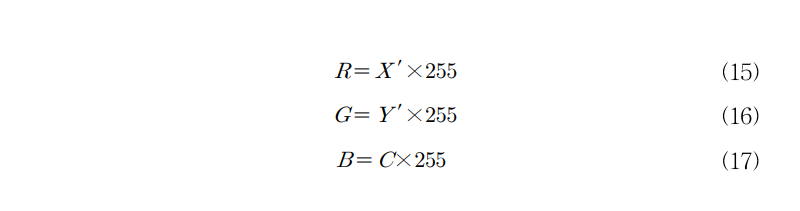

In [ ]:
def mapping_fn(norm_dic):
    for i, (k, v) in enumerate(norm_dic.items()):
        R = norm_dic[k]['X'] * 255
        G = norm_dic[k]['Y'] * 255
        B = norm_dic[k]['C'] * 255

        norm_dic[k]['X'] = R
        norm_dic[k]['Y'] = G
        norm_dic[k]['C'] = B

    return norm_dic

In [ ]:
mapping_dic = mapping_fn(norm_dic)

In [ ]:
mapping_dic

{1: {'X': 122.94349359586347,
  'Y': 62.594186011629326,
  'C': 250.46428978443146,
  't': 1,
  'n': 0},
 2: {'X': 96.3967470030435,
  'Y': 73.86810522992855,
  'C': 250.46428978443146,
  't': 1,
  'n': 1},
 3: {'X': 83.73873063957241,
  'Y': 94.43612645895004,
  'C': 250.46428978443146,
  't': 1,
  'n': 2},
 4: {'X': 81.17649632668372,
  'Y': 107.99320846150175,
  'C': 250.46428978443146,
  't': 1,
  'n': 3},
 5: {'X': 72.80868866404127,
  'Y': 130.23029550765241,
  'C': 250.46428978443146,
  't': 1,
  'n': 4},
 6: {'X': 118.9874161086066,
  'Y': 110.52505640548738,
  'C': 250.46428978443146,
  't': 1,
  'n': 5},
 7: {'X': 107.95763930516158,
  'Y': 111.84069715538729,
  'C': 250.46428978443146,
  't': 1,
  'n': 6},
 8: {'X': 94.45890889664275,
  'Y': 143.39039351310527,
  'C': 250.46428978443146,
  't': 1,
  'n': 7},
 9: {'X': 84.97267677155483,
  'Y': 173.8990284501688,
  'C': 250.46428978443146,
  't': 1,
  'n': 8},
 10: {'X': 125.5961150911172,
  'Y': 113.0911309206202,
  'C': 250

# 시공간 지도 생성
이미지의 한 축을 시간의 축으로 설정하여 이미지 생성 진행
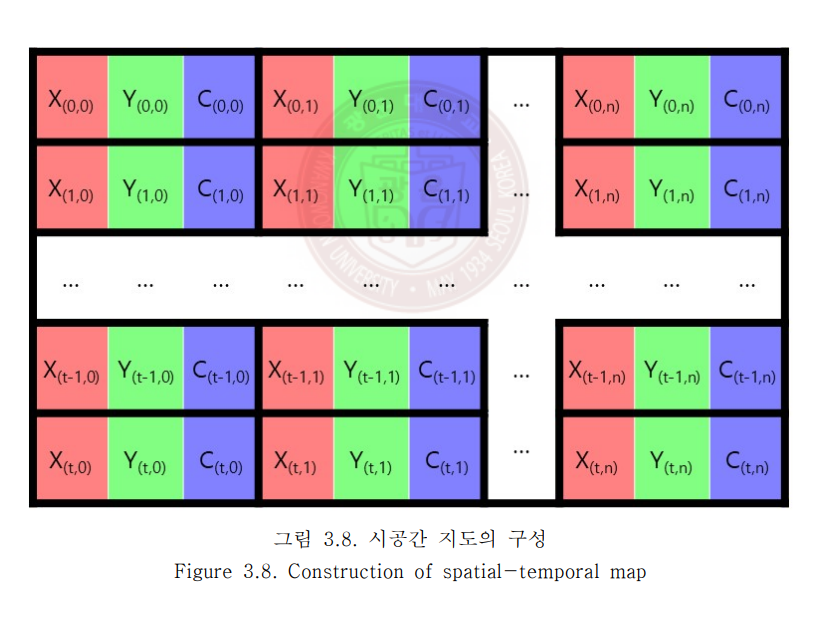

In [ ]:
def save_image_from_dict(data, output_path):
    # 이미지 크기 설정
    max_x = max(data[key]['n'] for key in data)
    # max_y = max(data[key]['t'] for key in data)
    # image_width = int(max_x) + 1  # x 좌표의 최댓값 + 1
    # image_height = int(max_y) + 1  # y 좌표의 최댓값 + 1
    image_width = 224
    image_height = 224

    # 이미지 생성 (흰색 배경)
    image = np.full((image_height, image_width, 3), 0, dtype=np.uint8)

    # 데이터를 이미지에 플로팅
    for key, value in data.items():
        # C 값을 BGR 색상으로 변환
        color_r = value['X']  # X 값을 R로 사용
        color_g = value['Y']  # Y 값을 G로 사용
        color_b = value['C']
        x = value['n']  # n 값을 x좌표로 사용
        y = value['t']  # t 값을 y좌표로 사용

        # 이미지에 점 그리기
        cv2.circle(image, (x, y), radius=2, color=(color_b, color_g, color_r), thickness=-1)

    # 이미지 저장
    cv2.imwrite(output_path, image)
    print(f"Image saved to {output_path}")

# 주어진 데이터를 사용하여 이미지 생성 및 저장
save_image_from_dict(mapping_dic, '/content/drive/MyDrive/KDT 3차 프로젝트/데이터_2/NIA_SL_WORD0001_REAL01_F.png')


Image saved to /content/drive/MyDrive/KDT 3차 프로젝트/데이터_2/NIA_SL_WORD0001_REAL01_F.png


# 영상 이미지 저장
좌표 전처리 후 이미지 저장

In [ ]:
path = '/content/drive/MyDrive/3차 데이터/front_01'
videos = os.listdir(path)

def video_change_image():
    for i, video in enumerate(videos):
        v_name = video.split('.')[0]
        dir = os.path.join(path, videos[i])
        dic, X_max, X_min, Y_max, Y_min = video_landmark_dic(f'{path}/{video}')
        norm_dic = dic_normalization(dic)
        mapping_dic = mapping_fn(norm_dic)
        save_image_from_dict(mapping_dic, f'/content/drive/MyDrive/KDT 3차 프로젝트/데이터_이미지/{v_name}.png')

video_change_image()

Image saved to /content/drive/MyDrive/KDT 3차 프로젝트/데이터_이미지/NIA_SL_WORD2119_REAL01_F.png
Image saved to /content/drive/MyDrive/KDT 3차 프로젝트/데이터_이미지/NIA_SL_WORD2121_REAL01_F.png
Image saved to /content/drive/MyDrive/KDT 3차 프로젝트/데이터_이미지/NIA_SL_WORD2122_REAL01_F.png
Image saved to /content/drive/MyDrive/KDT 3차 프로젝트/데이터_이미지/NIA_SL_WORD2123_REAL01_F.png
Image saved to /content/drive/MyDrive/KDT 3차 프로젝트/데이터_이미지/NIA_SL_WORD2124_REAL01_F.png
Image saved to /content/drive/MyDrive/KDT 3차 프로젝트/데이터_이미지/NIA_SL_WORD2125_REAL01_F.png
Image saved to /content/drive/MyDrive/KDT 3차 프로젝트/데이터_이미지/NIA_SL_WORD2126_REAL01_F.png
Image saved to /content/drive/MyDrive/KDT 3차 프로젝트/데이터_이미지/NIA_SL_WORD2127_REAL01_F.png
Image saved to /content/drive/MyDrive/KDT 3차 프로젝트/데이터_이미지/NIA_SL_WORD2128_REAL01_F.png
Image saved to /content/drive/MyDrive/KDT 3차 프로젝트/데이터_이미지/NIA_SL_WORD2129_REAL01_F.png
Image saved to /content/drive/MyDrive/KD

UnboundLocalError: local variable 'X_max' referenced before assignment